# Figure 5: Parametric Bootstrap

<div style="text-align: justify">
This code is used to create **Figure 5** in the **Apples with Apples** paper (Bonse et al. in prep). The Figure illustrates how the parametric bootstrap introduced in the paper works. The figure is composed of 2 subplots: first, a visualization of the resampling procedure which gives us the list of bootstrap samples (with size $B$). Second, a sequence of three histograms which show how the distribution of $p(T^* = x | H_0)$ converges as $B$ gets larger (under the assumption of Gaussian noise). 

In addition to the plots shown in the paper we also show histograms for the convergence of $p(T^* = x | H_0)$ under the assumption of Laplacian noise.
</div>

## Imports

In [1]:
import os
import json

import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# bokeh visualization
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, CustomJS, Select, Label, Div, Legend, Span
from bokeh.layouts import column, row

# applefy
from applefy.utils import AperturePhotometryMode, estimate_reference_positions, \
    center_subpixel, get_flux
from applefy.utils.data_handling import load_adi_data, read_apples_with_apples_root,\
    open_fits

from applefy.statistics import TTest, LaplaceBootstrapTest
from applefy.statistics.bootstrapping import GaussianBootstrapTest

## Data Loading

<div style="text-align: justify">
Figure 5 is based on the signal and noise values extracted in [Figure 01](01_What_is_a_detection.ipynb). Thus, we use the same code to extract the values.

In order to run the code **make sure to download the data from Zenodo and [read the instructions](../02_paper_data.md) on how to setup the files**.
</div>

In [2]:
experiment_root = read_apples_with_apples_root()

Data in the APPLES_ROOT_DIR found. Location: /Users/markusbonse/Desktop/


<div style="text-align: justify">
Set the path to one example residual and the config file used to create it. The config file is used to obtain the position at which the artificial planet was inserted.
</div>

In [3]:
fake_planet_residual_path = os.path.join(
    experiment_root, 
    "70_results/detection_limits/Beta_Pic_non_stacked/pca_residuals/pca_020_ID_0115f.fits")

fake_planet_config_path = os.path.join(
     experiment_root, 
    "70_results/detection_limits/Beta_Pic_non_stacked/configs_cgrid/exp_ID_0115f.json")

Open the .fits file with the fake planet residual and load the planet position from the config file.

In [4]:
planet_residual = open_fits(fake_planet_residual_path)

with open(fake_planet_config_path) as json_file:
    fake_planet_config = json.load(json_file)

# The last two values in "planet_position" are the separation from the star and the position angle
planet_position = fake_planet_config["planet_position"][:2]

Estimate the positions for the noise apertures. 

In [5]:
# estimate reference positions for the noise
noise_positions = estimate_reference_positions(
    planet_position,
    center=center_subpixel(planet_residual),
    psf_fwhm_radius=2.1,
    angle_offset=5,  # more details are explained in the documentation of Figure 3.
    safety_margin=0.5)

In [6]:
noise_positions

[(45.16718454912184, 35.036050779529816, 8.4, 346.4788975654116),
 (45.05496390717036, 39.3827623578911, 8.4, 376.4788975654116),
 (42.784422191230746, 43.09101468670018, 8.4, 406.47889756541156),
 (38.963949220470184, 45.16718454912184, 8.4, 436.4788975654116),
 (34.617237642108904, 45.05496390717036, 8.4, 466.4788975654116),
 (30.908985313299823, 42.784422191230746, 8.4, 496.47889756541156),
 (28.832815450878158, 38.96394922047019, 8.4, 526.4788975654116),
 (28.945036092829636, 34.617237642108904, 8.4, 556.4788975654116),
 (31.215577808769254, 30.908985313299823, 8.4, 586.4788975654116),
 (35.03605077952982, 28.832815450878158, 8.4, 616.4788975654117)]

As in [Figure 01](01_What_is_a_detection.ipynb) we use the [AperturePhotometryMode](../../04_package/utils.rst#applefy.utils.aperture_photometry.AperturePhotometryMode) "ASS" and "AS" of applefy to calculate the aperture averages.

In [7]:
photometry_mode_planet = AperturePhotometryMode("ASS", psf_fwhm_radius=2.1, search_area=1.5)
photometry_mode_noise = AperturePhotometryMode("AS", psf_fwhm_radius=2.1)

In [8]:
# Compute the noise values
noise_flux = []
for tmp_pos in noise_positions:
    tmp_flux = get_flux(planet_residual,
                        tmp_pos[:2],
                        photometry_mode=photometry_mode_noise)[1]
    noise_flux.append(tmp_flux)
    
# Compute the planet flux
planet_flux = get_flux(planet_residual,
                       planet_position,
                       photometry_mode=photometry_mode_planet)[1]

## Compute the test statistic $T_{\text{obs}}$

As for the t-Test we need to compute the test statistic $T_{\text{obs}}$. We use the code of the [t-Test](../../04_package/statistics.rst#applefy.statistics.parametric.TTest) but only use its second return parameter.

In [9]:
test = TTest()
T_obs = test.test_2samp(planet_flux, noise_flux)[1]

T_obs

2.2804911538963033

## The Gaussian Bootstrap Test

<div style="text-align: justify">
For illustration purposes we resample from a Gaussian distribution in this example. This allows us to show that the parametric bootstrap test is equivalent to the t-Test if we make the same assumption about the noise. In reality we would never use bootstrapping if we want to assume a Gaussian noise as it is computationally expensive. However, the parametric bootstrap is not limited to the assumption of Gaussian noise. An example for Laplacian noise is shown at [the end of this page](05_Parametric_BS_Procedure.ipynb#Bootstrapping-for-Laplacian-noise).

We start the resampling by setting up a [GaussianBootstrapTest](../../04_package/statistics.rst#applefy.statistics.bootstrapping.GaussianBootstrapTest). The input of the GaussianBootstrapTest is our noise sample which is used to estimate the MLE parameters $\mu_{\text{MLE}}= \overline{\mathcal{X}}$ and $\sigma_{\text{MLE}} = \hat{\sigma}_{\mathcal{X}}$.
</div>

In [10]:
test_statistic = GaussianBootstrapTest(
    noise_flux, 
    num_cpus=8)

<div style="text-align: justify">
Now we can run the actual resampling using the function [run_bootstrap_experiment](../../04_package/statistics.rst#applefy.statistics.bootstrapping.BootstrapTest.run_bootstrap_experiment). The parameter *num_noise_values* gives the number of noise observations we want to resample. It should be equal to the same number of observations we extracted from our residual. This way we are able to account for the effect of the small sample statistics. The parameter *num_draws* gives the number of bootstrap samples we want to obtain ($B$). The *approximation_interval* is only needed if we want to restore our bootstrap lookup table later.

Note: The following code cell is computationally expensive. Consider reducing *num_draws*.
</div>

In [11]:
T_star_gauss = test_statistic.run_bootstrap_experiment(
    memory_size=5e6,
    num_noise_values=len(noise_flux),
    num_draws=1e8,  # num_draws=1e9 was used in the paper
    approximation_interval=np.linspace(-7, 7, 100000))

In [12]:
T_star_gauss.shape

(100000000,)

## Create the Subplots

Define the colors we use along all subplots.

In [13]:
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

### 1. Illustration of the Bootstrapping

The first subplot shows how we estimate the MLE parameters of the Gaussian distribution in order to use the for the resampling.

In [14]:
# Estimate the location and scale of the Gaussian we want to resample from.
gauss_loc = np.mean(noise_flux)
gauss_scale = np.std(noise_flux)

Draw 6 bootstrap samples as examples. Note, the +1 is for the signal (yellow in the Figure).

In [15]:
np.random.seed(42)
resamples =  [np.random.normal(loc=gauss_loc, 
                               scale=gauss_scale, 
                               size=len(noise_flux) + 1) 
              for i in range(6)]

A simple function to plot one of the 6 bootstrap samples.

In [16]:
def plot_samples(noise_in, 
                 planet_in,
                 axis_in,
                 idx):
    
    # if idx is None it is the actual data.
    # We plot it with different colors and labels
    if idx is None:
        color_noise = sns.color_palette("colorblind")[0]
        color_signal = sns.color_palette("colorblind")[1]
        noise_label = r"$X_1, X_2, ..., X_n$"
        signal_label = r"$Y_1$"
    else:
        color_noise = sns.color_palette("colorblind")[2]
        color_signal = sns.color_palette("colorblind")[8]
        noise_label = r"$X^*_1, X^*_2, ..., X^*_n$"
        signal_label = r"$Y^*_1$"
    
    # Compute the test statistic for the given bootstrap sample
    T_star = test.test_2samp(planet_in, noise_in)[1]
    
    axis_in.hlines(0, xmin=-200, xmax=200, color="black")
    
    # Plot the bootstrap sample
    axis_in.scatter(noise_in,
                    np.zeros_like(noise_in),
                    color = color_noise,
                    marker="x", lw=3, s=100,
                    label=noise_label)

    axis_in.scatter(planet_in,
                    np.zeros_like(planet_in),
                    color = color_signal,
                    marker="x", lw=3, s=100, 
                    label=signal_label)
    
    # Add the value of the test statistic as text
    if idx is None:
        t_text = r"$T_{obs}$" + " = {:.2f}".format(T_obs)
    else:
        t_text = r"$T^*_{}$".format(idx) + " = {:.2f}".format(T_star)
    
    axis_in.text(120, 0, t_text, 
                 ha="center", size=16, va="center",
                 bbox=dict(facecolor='white',
                           boxstyle="round",
                           edgecolor="white"))
    
    axis_in.set_xlim(-100, 135)
    axis_in.axis("off")

Create the final subplot.

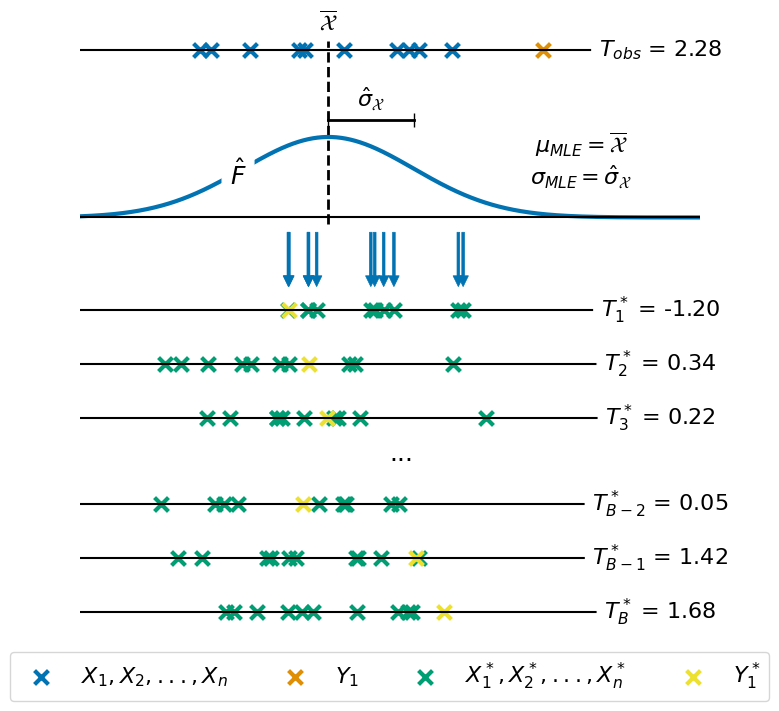

In [17]:
# Create the Layout with gridspec
fig = plt.figure(constrained_layout=False, figsize=(8, 8))

# We have 10 subplots stack on to of each other
# subplot 0: The input data
# subplot 1: Estimation of the MLE
# subplot 2: arrows from subplot 1 to subplots 3 - 9
# subplots 3 - 5: bootstrap examples
# subplot 6: Empty ...
# subplots 7 - 9: bootstrap examples
gs0 = fig.add_gridspec(10, 1, height_ratios=[1.5, 3, 1.,
                                             1, 1, 1, 0.5,
                                             1, 1, 1])

# 1.) Plot the observations ---------------------------------------
ax_observations = fig.add_subplot(gs0[0])
plot_samples(noise_flux, planet_flux, ax_observations, None)

ax_observations.text(gauss_loc, 0.035, 
                     r"$\overline{\mathcal{X}}$",
                     ha="center", size=16)

# 2.) Plot the MLE step -------------------------------------------
ax_mle = fig.add_subplot(gs0[1])

# Plot the gaussian
x = np.linspace(-200, 200, 2000)

ax_mle.plot(x, stats.norm.pdf(x, loc=gauss_loc, scale=gauss_scale), 
            label="Noise PDF",
            color=sns.color_palette("colorblind")[0], lw=3)

ax_mle.set_xlim(-100, 135)
ax_mle.set_ylim(-0.001, 0.019)
ax_mle.hlines(0, xmin=-200, xmax=200, color="black")
ax_mle.axes.get_xaxis().set_ticklabels([])
ax_mle.axes.get_yaxis().set_ticklabels([])
ax_mle.axis("off")

ax_mle.axvline(gauss_loc,
               ymin=0, ymax=1.4, ls="--",
               color="black", 
               lw=2,
               zorder=-1,
               clip_on=False)

# Add Text
ax_mle.text(90, 0.005, 
            r"$\mu_{MLE} = \overline{\mathcal{X}}$" + " \n" +  
            r"$\sigma_{MLE} = \hat{\sigma}_{\mathcal{X}}$",
            ha="center", size=16,
            bbox=dict(facecolor='white',
                      boxstyle="round",
                      edgecolor="white"))

ax_mle.text(-40, 0.005, 
            r"$\hat{F}$",
            ha="center", size=18,
            bbox=dict(facecolor='white',
                      boxstyle="round",
                      edgecolor="white"))

# Add dashed line
line = plt.Line2D((gauss_loc, gauss_loc + gauss_scale), 
                  (0.015, 0.015), lw=2, color="black", 
                  marker="|", ms=10)

ax_mle.add_line(line)

ax_mle.text(gauss_loc + gauss_scale/2, 0.017, 
            r"$\hat{\sigma}_{\mathcal{X}}$",
            ha="center", size=16,)

# 3.) Plot the arrows ---------------------------------------------
ax_top_space = fig.add_subplot(gs0[2])

ax_top_space.axis("off")
ax_top_space.set_xlim(-100, 135)
ax_top_space.set_ylim(-1, 1)

# one arrow for each noise and signal value
for tmp_sample in resamples[0]:
    ax_top_space.arrow(tmp_sample, 1.1, 0, -2.5, 
                       clip_on=False, width=1, lw=0.5,
                       length_includes_head=True,
                       head_length=0.5,
                       head_width=4,
                       color = sns.color_palette("colorblind")[0])

# 4.) Plot bootstrap examples -------------------------------------
ax_rs1 = fig.add_subplot(gs0[3])
ax_rs2 = fig.add_subplot(gs0[4])
ax_rs3 = fig.add_subplot(gs0[5])

# Plot the Samples and Re-samples ---------------------------------
plot_samples(resamples[0][:-1], resamples[0][-1], ax_rs1, "1")
plot_samples(resamples[1][:-1], resamples[1][-1], ax_rs2, "2")
plot_samples(resamples[2][:-1], resamples[2][-1], ax_rs3, "3")

# 5.) Plot Empty ... ----------------------------------------------
ax_middle_space = fig.add_subplot(gs0[6])
ax_middle_space.axis("off")
ax_middle_space.text(0, 0, "...", fontsize=18)
ax_middle_space.set_xlim(-1, 1)
ax_middle_space.set_ylim(-1, 1)

# 6.) Plot bootstrap examples -------------------------------------
ax_rs4 = fig.add_subplot(gs0[7])
ax_rs5 = fig.add_subplot(gs0[8])
ax_rs6 = fig.add_subplot(gs0[9])

# Plot the Samples and Re-samples
plot_samples(resamples[3][:-1], resamples[3][-1], ax_rs4, "{B-2}")
plot_samples(resamples[4][:-1], resamples[4][-1], ax_rs5, "{B-1}")
plot_samples(resamples[5][:-1], resamples[5][-1], ax_rs6, "{B}")

# 7.) Add a Legend ------------------------------------------------
ax_rs6.legend(ax_observations.get_legend_handles_labels()[0] + \
                  ax_rs6.get_legend_handles_labels()[0],
              ax_observations.get_legend_handles_labels()[1] + \
                  ax_rs6.get_legend_handles_labels()[1],
              ncol=4,
              fontsize=16, 
              loc='lower center',
              bbox_to_anchor=(0.5, -1.8))

fig.patch.set_facecolor('white')
plt.savefig("./05_01_resample.pdf",
            bbox_inches='tight')

### 2. Distribution of $p(T^* = x | H_0)$

The second subplot shows how the distribution $p(T^* = x | H_0)$ converges towards the t-distribution. For this we create histograms. Each histogram is based on a subset of the *T_star_gauss* we computed earlier.

In [18]:
# Create the data and setups
np.random.seed(42)
idx_1 = np.random.randint(0, T_star_gauss.shape[0]-1, int(1e3))
idx_2 = np.random.randint(0, T_star_gauss.shape[0]-1, int(1e4))
idx_3 = np.random.randint(0, T_star_gauss.shape[0]-1, int(1e7))

T_set_1 = pd.DataFrame({"T": T_star_gauss[idx_1],
                        "above": T_star_gauss[idx_1] > T_obs})
T_set_2 = pd.DataFrame({"T": T_star_gauss[idx_2],
                        "above": T_star_gauss[idx_2] > T_obs})
T_set_3 = pd.DataFrame({"T": T_star_gauss[idx_3],
                        "above": T_star_gauss[idx_3] > T_obs})

# The FPF / p-value of the test is given by the fraction of observations 
# larger than T_obs. See Equation (3) in the paper.
fpf_1 = np.sum(T_star_gauss[idx_1] > T_obs) / len(T_star_gauss[idx_1])
fpf_2 = np.sum(T_star_gauss[idx_2] > T_obs) / len(T_star_gauss[idx_2])
fpf_3 = np.sum(T_star_gauss[idx_3] > T_obs) / len(T_star_gauss[idx_3])

A small function which plots one of the histograms.

In [19]:
# Limits. Most values of T are between -7 and +7.
axis_limit = 7

def plot_histogram(data_in, 
                   numb_bins, 
                   axis_in,
                   fpf_in):
    
    x = np.linspace(-axis_limit, axis_limit, 1000)
    
    # Plot the pdf of the t-distribution
    axis_in.plot(x, stats.t.pdf(x, df=9),
                 color=sns.color_palette("colorblind")[1], 
                 lw=3,
                 label="T-Distribution " + r"$\nu = 9$")
    
    # Plot the histogram based on the bootstrap samples
    sns.histplot(data=data_in, 
                 x="T", 
                 hue="above",
                 palette=[sns.color_palette("colorblind")[0], "red"],
                 bins=numb_bins, 
                 stat="density", 
                 multiple="stack",
                 binrange=(-axis_limit, axis_limit),
                 ax=axis_in,
                 legend=False)
    
    # Add Text and Labels
    axis_in.set_xlim(-7, 7)
    axis_in.set_yscale("log")
    axis_in.yaxis.grid()
    axis_in.tick_params(axis='both', which='major', labelsize=14)
    axis_in.set_yticks([1e-04, 1e-03, 1e-02, 1e-01])
    
    axis_in.axvline(x=T_obs,
                    ymin=0,
                    ymax=1,
                    c="black",
                    linewidth=2)

    axis_in.set_ylabel("$p(T^*=x|H_0)$", fontsize=16)
    fpf_text = (5, 0.1, 16)

    axis_in.text(
        -5, 0.1, 
        r"$B$" + " = {:.1e}".format(data_in.shape[0]),
        ha="center", size=16,
        bbox=dict(
            facecolor='white',
            boxstyle="round",
            edgecolor="white"))
    
    axis_in.text(fpf_text[0], fpf_text[1], 
                 r"FPF = {:.4f}".format(fpf_in), 
                 ha="center", size=fpf_text[2],
                 bbox=dict(
                     facecolor='white',
                     boxstyle="round",
                     edgecolor="white"))

Create the actual plot. Note: this can take a while since *sns.histplot* has to calculate the histogram.

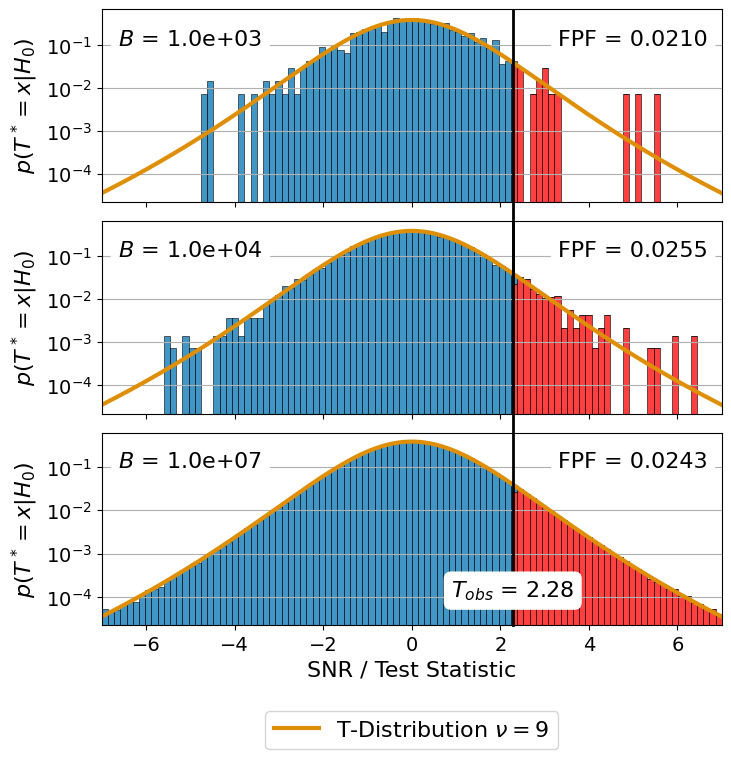

In [20]:
# Create the Layout with gridspec
fig = plt.figure(constrained_layout=False, figsize=(8, 8))
gs0 = fig.add_gridspec(3, 1, height_ratios=[1, 1, 1])
gs0.update(hspace=0.1, wspace=0.2)

ax_b1 = fig.add_subplot(gs0[0])
ax_b2 = fig.add_subplot(gs0[1])
ax_b3 = fig.add_subplot(gs0[2])

# Plot the histograms
plot_histogram(T_set_1, 100, ax_b1, fpf_1)
plot_histogram(T_set_2, 100, ax_b2, fpf_2)
plot_histogram(T_set_3, 100, ax_b3, fpf_3)

# Add a vertical line at the position of T_obs
ax_b2.axvline(x=T_obs,
              ymin=-1.1,
              ymax=1.1,
              c="black",
              linewidth=2,
              zorder=10, 
              clip_on=False)

# Clean up the Labels
ax_b1.axes.get_xaxis().set_ticklabels([])
ax_b1.set_xlabel("")
ax_b2.axes.get_xaxis().set_ticklabels([])
ax_b2.set_xlabel("")
ax_b3.set_xlabel("SNR / Test Statistic", fontsize=16)

# Add captions
ax_b3.text(T_obs, 0.0001, r"$T_{obs}$" + " = {:.2f}".format(T_obs), 
           ha="center", size=16,
           bbox=dict(facecolor='white',
                     boxstyle="round",
                     edgecolor="white"))

# Add a legend
ax_b3.legend(ncol=1,
             fontsize=16, 
             loc='lower center',
             bbox_to_anchor=(0.5, -.7))

# Save the plot
fig.patch.set_facecolor('white')
plt.savefig("./05_02_bs_histogram.pdf",
            bbox_inches='tight')

We merged the two subplots using Adobe Illustrator.

## Bootstrapping for Laplacian noise

<div style="text-align: justify">
This is an additional example which compares the distribution of $p(T^*=x | H_0)$ under two different assumptions: Gaussian noise and Laplacian noise. For this we first have to run the bootstrapping again for Laplacian noise.  
</div>

### 1. Creation of Bootstrap samples

We start by setting up a [LaplaceBootstrapTest](../../04_package/statistics.rst#applefy.statistics.bootstrapping.LaplaceBootstrapTest).

In [21]:
laplace_statistic = LaplaceBootstrapTest(
    noise_flux, num_cpus=8)

Now we can run the actual resampling using the function [run_bootstrap_experiment](../../04_package/statistics.rst#applefy.statistics.bootstrapping.BootstrapTest.run_bootstrap_experiment). 

Note: The following code cell is computationally expensive. Consider reducing *num_draws*.

In [22]:
T_star_laplace = laplace_statistic.run_bootstrap_experiment(
    memory_size=5e6,
    num_noise_values=len(noise_flux),
    num_draws=1e8,
    approximation_interval=np.linspace(-7, 7, 100000))

In [23]:
T_star_laplace.shape

(100000000,)

### 2. Compute the Histograms

In order to be able to show the interactive plots with bokeh on a static html page we have to pre-compute the histograms for different $B$ and noise assumptions.

The results are sorted in *T_star* which is why we shuffle them here.

In [24]:
np.random.shuffle(T_star_laplace)
np.random.shuffle(T_star_gauss)

Compute the bins and values of the histograms.

In [25]:
num_draws = np.logspace(3, 8, 6)
histogram_bins = np.linspace(-7, 7, 100)

# a dict to save all histograms
final_histograms = dict()

for tmp_B in num_draws:
    
    # compute the histogram for the gaussian assumption
    tmp_hist_gauss, edges = np.histogram(
        # using the B random values of T_star 
        # (see shuffle step before)
        T_star_gauss[:int(tmp_B)], 
        density=True,
        bins=histogram_bins)
    
    # compute the histogram for the laplacian assumption
    tmp_hist_laplace, edges = np.histogram(
        T_star_laplace[:int(tmp_B)], 
        density=True,
        bins=histogram_bins)
    
    # compute the fpf (equation 3 in the apples with apples paper)
    fpf_gauss = np.sum(T_star_gauss[:int(tmp_B)] > T_obs) / \
        len(T_star_gauss[:int(tmp_B)])
    fpf_laplace = np.sum(T_star_laplace[:int(tmp_B)] > T_obs) / \
        len(T_star_laplace[:int(tmp_B)])
    
    # We want to different colors for the part of the histogram larger than T_obs. 
    # This is why we split the histogram into two parts
    cut_off_idx = np.where(edges[1:] > T_obs)[0][0]
    
    # Save the results
    final_histograms["{:.0e}".format(tmp_B) + "_Gauss"] = (
        tmp_hist_gauss[:cut_off_idx],
        tmp_hist_gauss[cut_off_idx:],
        "{:.4f}".format(fpf_gauss))
    
    final_histograms["{:.0e}".format(tmp_B) + "_Laplace"] = (
        tmp_hist_laplace[:cut_off_idx],
        tmp_hist_laplace[cut_off_idx:],
        "{:.4f}".format(fpf_laplace))

### 3. Create the Plot

In [26]:
# Start the bokeh for jupyter notebooks
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

Setup the same colors as used for the previous plot.

In [27]:
color_blue = tuple([int(i*255) for i in sns.color_palette("colorblind")[0]])
color_t_dist = tuple([int(i*255) for i in sns.color_palette("colorblind")[1]])
color_red = "red"

Create the actual interactive Plot.

In [30]:
# 1. Setup the figure ----------------------------------------------------------
p = figure(width=750, height=300, 
           toolbar_location=None,
           tools = [],
           title="Parametric Bootstrap Distribution",
           y_axis_type="log", 
           y_range=(1e-5, 3),
           x_range=(-7, 7))

# 2. Plot the histogram --------------------------------------------------------
# The ColumnDataSource are used for the interactive updates
# s_all_histograms contains all available histograms
s_all_histograms = ColumnDataSource(data=final_histograms)

# s_hist_data_small and s_hist_data_large contain the current histogram
s_hist_data_small = ColumnDataSource(
    data=dict(top=final_histograms["1e+05_Gauss"][0], 
              bottom=([1e-7,]*99)[:cut_off_idx], 
              left=edges[:-1][:cut_off_idx], 
              right=edges[1:][:cut_off_idx]))

s_hist_data_large = ColumnDataSource(
    data=dict(top=final_histograms["1e+05_Gauss"][1], 
              bottom=([1e-7,]*99)[cut_off_idx:], 
              left=edges[:-1][cut_off_idx:], 
              right=edges[1:][cut_off_idx:]))

# Draw the actual histogram ----------------------------------------------------
p.quad(top="top", bottom="bottom", left="left", right="right",
       source=s_hist_data_small,
       fill_color=color_blue, 
       line_color="white")

p.quad(top="top", bottom="bottom", left="left", right="right",
       source=s_hist_data_large,
       fill_color=color_red, 
       line_color="white")

# 3. Add labels ----------------------------------------------------------------
p.xaxis.axis_label = "SNR / Test Statistc"
p.yaxis.axis_label = r"$$p(T^* = x| H_0)$$"
mytext = Label(x=3, y=0.2,
               text=r'$$T_{\text{obs}} = 2.28$$')
p.add_layout(mytext)

# 4. Draw T_obs vertical line --------------------------------------------------
vline = Span(location=T_obs, 
             dimension='height', 
             line_color='black', 
             line_width=3)
p.renderers.extend([vline,])


# 5. Plot the t-distibution ----------------------------------------------------
x = np.linspace(-7.0, 7.0, 100)
pdf = stats.t.pdf(x, df=9)
p.line(x, pdf, line_width=3, line_color=color_t_dist,
       legend_label="t-distribution")
p.legend.location = "bottom_left"


# 6. Add fpf Text box ----------------------------------------------------------
fpf_text = Div(text="""<p style="color:black;
                                 font-size:20px;
                                 font-weight: bold;">FPF = 0.0245 </p>""",
width=300, height=50, margin=(30, 10, 10, 50))

# 7. Add interaction -----------------------------------------------------------
# JavaScript code for the update
code = """
    // 1.) Select the histogram
    const hist_new = s_all_histograms.data[B.value + "_" + dist.value]
    
    // 2.) Update the FPF
    const tmp_fpf = hist_new[2]
    fpf_text.text = '<p style="color:black; font-size:20px; font-weight:'
        + ' bold;">FPF = ' + tmp_fpf + '</p>'
    
    
    // 3.) update the values
    s_hist_data_small.data = {
         top: hist_new[0], 
         bottom: s_hist_data_small.data.bottom, 
         left: s_hist_data_small.data.left, 
         right: s_hist_data_small.data.right}; 
         
    s_hist_data_large.data = {
         top: hist_new[1], 
         bottom: s_hist_data_large.data.bottom, 
         left: s_hist_data_large.data.left, 
         right: s_hist_data_large.data.right};    
    
"""
# create the Dropdown menus
select_B = Select(title="B:", value="1e+05", 
                  options=["{:.0e}".format(i) for i in num_draws])

select_dist = Select(title="Assumed noise:", 
                     value="Gauss",
                     options=["Gauss", "Laplace"])

# Setup the callback function
callback = CustomJS(args=dict(
    B=select_B,
    dist=select_dist,
    fpf_text=fpf_text,
    s_all_histograms=s_all_histograms,
    s_hist_data_large=s_hist_data_large,
    s_hist_data_small=s_hist_data_small), 
                    code=code)

select_B.js_on_change('value', callback)
select_dist.js_on_change('value', callback)

# 8. Show the plot -------------------------------------------------------------
show(column(row(select_B, select_dist, fpf_text), p))